In [11]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import time
import datetime
import cv2
from matplotlib import pyplot as plt
from IPython import display


2024-07-04 16:17:47.498050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 16:17:47.498178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 16:17:47.625824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
#!wget 10SmoQQODtYSbdrBPcT-LlUoAz8iewBEj

--2024-07-04 09:11:57--  http://10smoqqodtysbdrbpct-lluoaz8iewbej/
Resolving 10smoqqodtysbdrbpct-lluoaz8iewbej (10smoqqodtysbdrbpct-lluoaz8iewbej)... failed: Name or service not known.
wget: unable to resolve host address '10smoqqodtysbdrbpct-lluoaz8iewbej'


In [3]:
#!rm -rf /content/cover_images

In [14]:
#!unzip /content/images_dataset.zip
#!unzip "/kaggle/input/cover-images-split"

unzip:  cannot find or open /kaggle/input/cover-images-split, /kaggle/input/cover-images-split.zip or /kaggle/input/cover-images-split.ZIP.


In [15]:
PATH = "/kaggle/input/cover-images-split/content/images_dataset"

In [16]:
def display_image(img,gray=False):
    """Display image stored as a tensor"""
    if gray:
        plt.imshow(img.numpy()/255.0, cmap='gray')
    else:
        plt.imshow(img.numpy()/255.0)

    plt.axis('off')
    plt.show()

In [17]:
#The featured training set consist of 436 images
BUFFER_SIZE = 436
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 1170 x 827 in size
IMG_WIDTH = 768#832#827
IMG_HEIGHT = 1024#1184#1170

In [18]:

# Define the path to the images directory
image_directory = PATH

# List all image filenames in the directory
image_filenames = os.listdir(image_directory)

In [19]:
image_filenames[:5]

['input376.jpg', 'target91.jpg', 'input219.jpg', 'input31.jpg', 'input58.jpg']

In [20]:
import fnmatch
# Separate target and input images
target_files = []
input_files = []
for filename in image_filenames:
    if fnmatch.fnmatch(filename,"target*.jpg"):
        target_files.append(filename)
    else:
        input_files.append(filename)


In [21]:
assert len(target_files) == len(input_files)

In [22]:
input_files.sort()
target_files.sort()

print(input_files[:5])
print(target_files[:5])

['input1.jpg', 'input10.jpg', 'input100.jpg', 'input101.jpg', 'input102.jpg']
['target1.jpg', 'target10.jpg', 'target100.jpg', 'target101.jpg', 'target102.jpg']


In [23]:

input_files = [os.path.join(PATH, filename) for filename in input_files]
target_files = [os.path.join(PATH, filename) for filename in target_files]


In [24]:

from sklearn.model_selection import train_test_split

input_files_train, input_files_test, target_files_train, target_files_test = train_test_split(input_files, target_files, train_size=0.8, random_state=42)


In [25]:
def load_image(input_image, real_image):
    # Read and decode an image file to a uint8 tensor
    input_image = tf.io.read_file(input_image)
    image = tf.io.decode_jpeg(input_image)
    x1 = image.shape[0]
    x2 = image.shape[1]
    image = tf.reshape(tf.broadcast_to(image, (x1, x2, 3)),  (x1, x2, 3))

    real_image = tf.io.read_file(real_image)
    real_image = tf.io.decode_jpeg(real_image)

    # Convert both images to float32 tensors
    input_image = tf.cast(image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

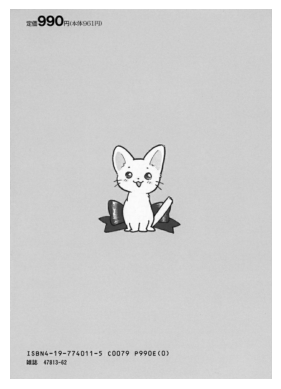

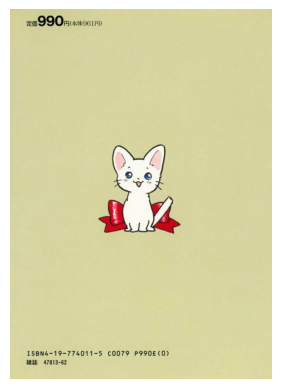

In [26]:
#testing load_image
a,b = load_image(input_files_train[0], target_files_train[0])
display_image(a)
display_image(b)

In [27]:
def resize(input_image, real_image, height=IMG_HEIGHT, width=IMG_WIDTH):
    input_image = tf.image.resize(input_image, [height, width],
                                    method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    # Resizing
    input_image, real_image = resize(input_image, real_image, 1054, 858)

    # Random cropping back to og size
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image


#load image and add jitter and normalise
def load_image_train(input_image, real_image):
    input_image, real_image = load_image(input_image, real_image)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image



In [28]:
def load_image_test(input_image, real_image):
  input_image, real_image = load_image(input_image, real_image)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

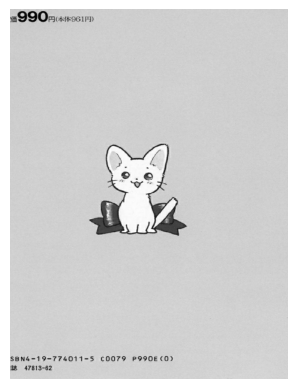

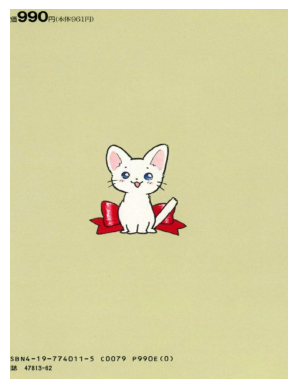

In [29]:
#testing random_jitter
c,d = random_jitter(a,b)
display_image(c)
display_image(d)

In [30]:

def train_data_generator():
  for i in range(len(input_files_train)):
    yield load_image_train(input_files_train[i], target_files_train[i])

def test_data_generator():
  for i in range(len(input_files_test)):
    yield load_image_test(input_files_test[i], target_files_test[i])

In [31]:
train_dataset = tf.data.Dataset.from_generator(train_data_generator, output_types=(tf.float32, tf.float32))


In [32]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


In [33]:
test_dataset = tf.data.Dataset.from_generator(test_data_generator, output_types=(tf.float32, tf.float32))
train_dataset = train_dataset.batch(BATCH_SIZE)

In [34]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result





In [35]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


In [36]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH,  3])
  print(f"Input shape: {inputs.shape}")

  down_stack = [
      downsample(64, 4, apply_batchnorm=False),  # (585, 414, 64)
      downsample(128, 4),  # (293, 207, 128)
      downsample(256, 4),  # (147, 104, 256)
      downsample(512, 4),  # (74, 52, 512)
      downsample(512, 4),  # (37, 26, 512)
      downsample(512, 4),  # (19, 13, 512)
      downsample(512, 4),  # (10, 7, 512)
      downsample(512, 4),  # (5, 4, 512)
  ]

  up_stack = [
      upsample(512, 4, apply_dropout=True),  # (10, 8, 1024)
      upsample(512, 4, apply_dropout=True),  # (20, 16, 1024)
      upsample(512, 4, apply_dropout=True),  # (40, 32, 1024)
      upsample(512, 4),  # (80, 64, 1024)
      upsample(256, 4),  # (160, 128, 512)
      upsample(128, 4),  # (320, 256, 256)
      upsample(64, 4),  # (640, 512, 128)
      upsample(32, 4),  # (1280, 1024, 64)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh')  # (batch_size, 1170, 827, 3)




  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
    #print(f"Downsample shape: {x.shape}")

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    #print(f"shape of x :{x.shape}, shape of skip : {skip.shape}")
    x = tf.keras.layers.Concatenate()([x, skip])
    #print(f"Upsample shape: {x.shape}")

  x = last(x)
  #print(f"Output shape: {x.shape}")
  return tf.keras.Model(inputs=inputs, outputs=x)


Input shape: (None, 1024, 768, 3)


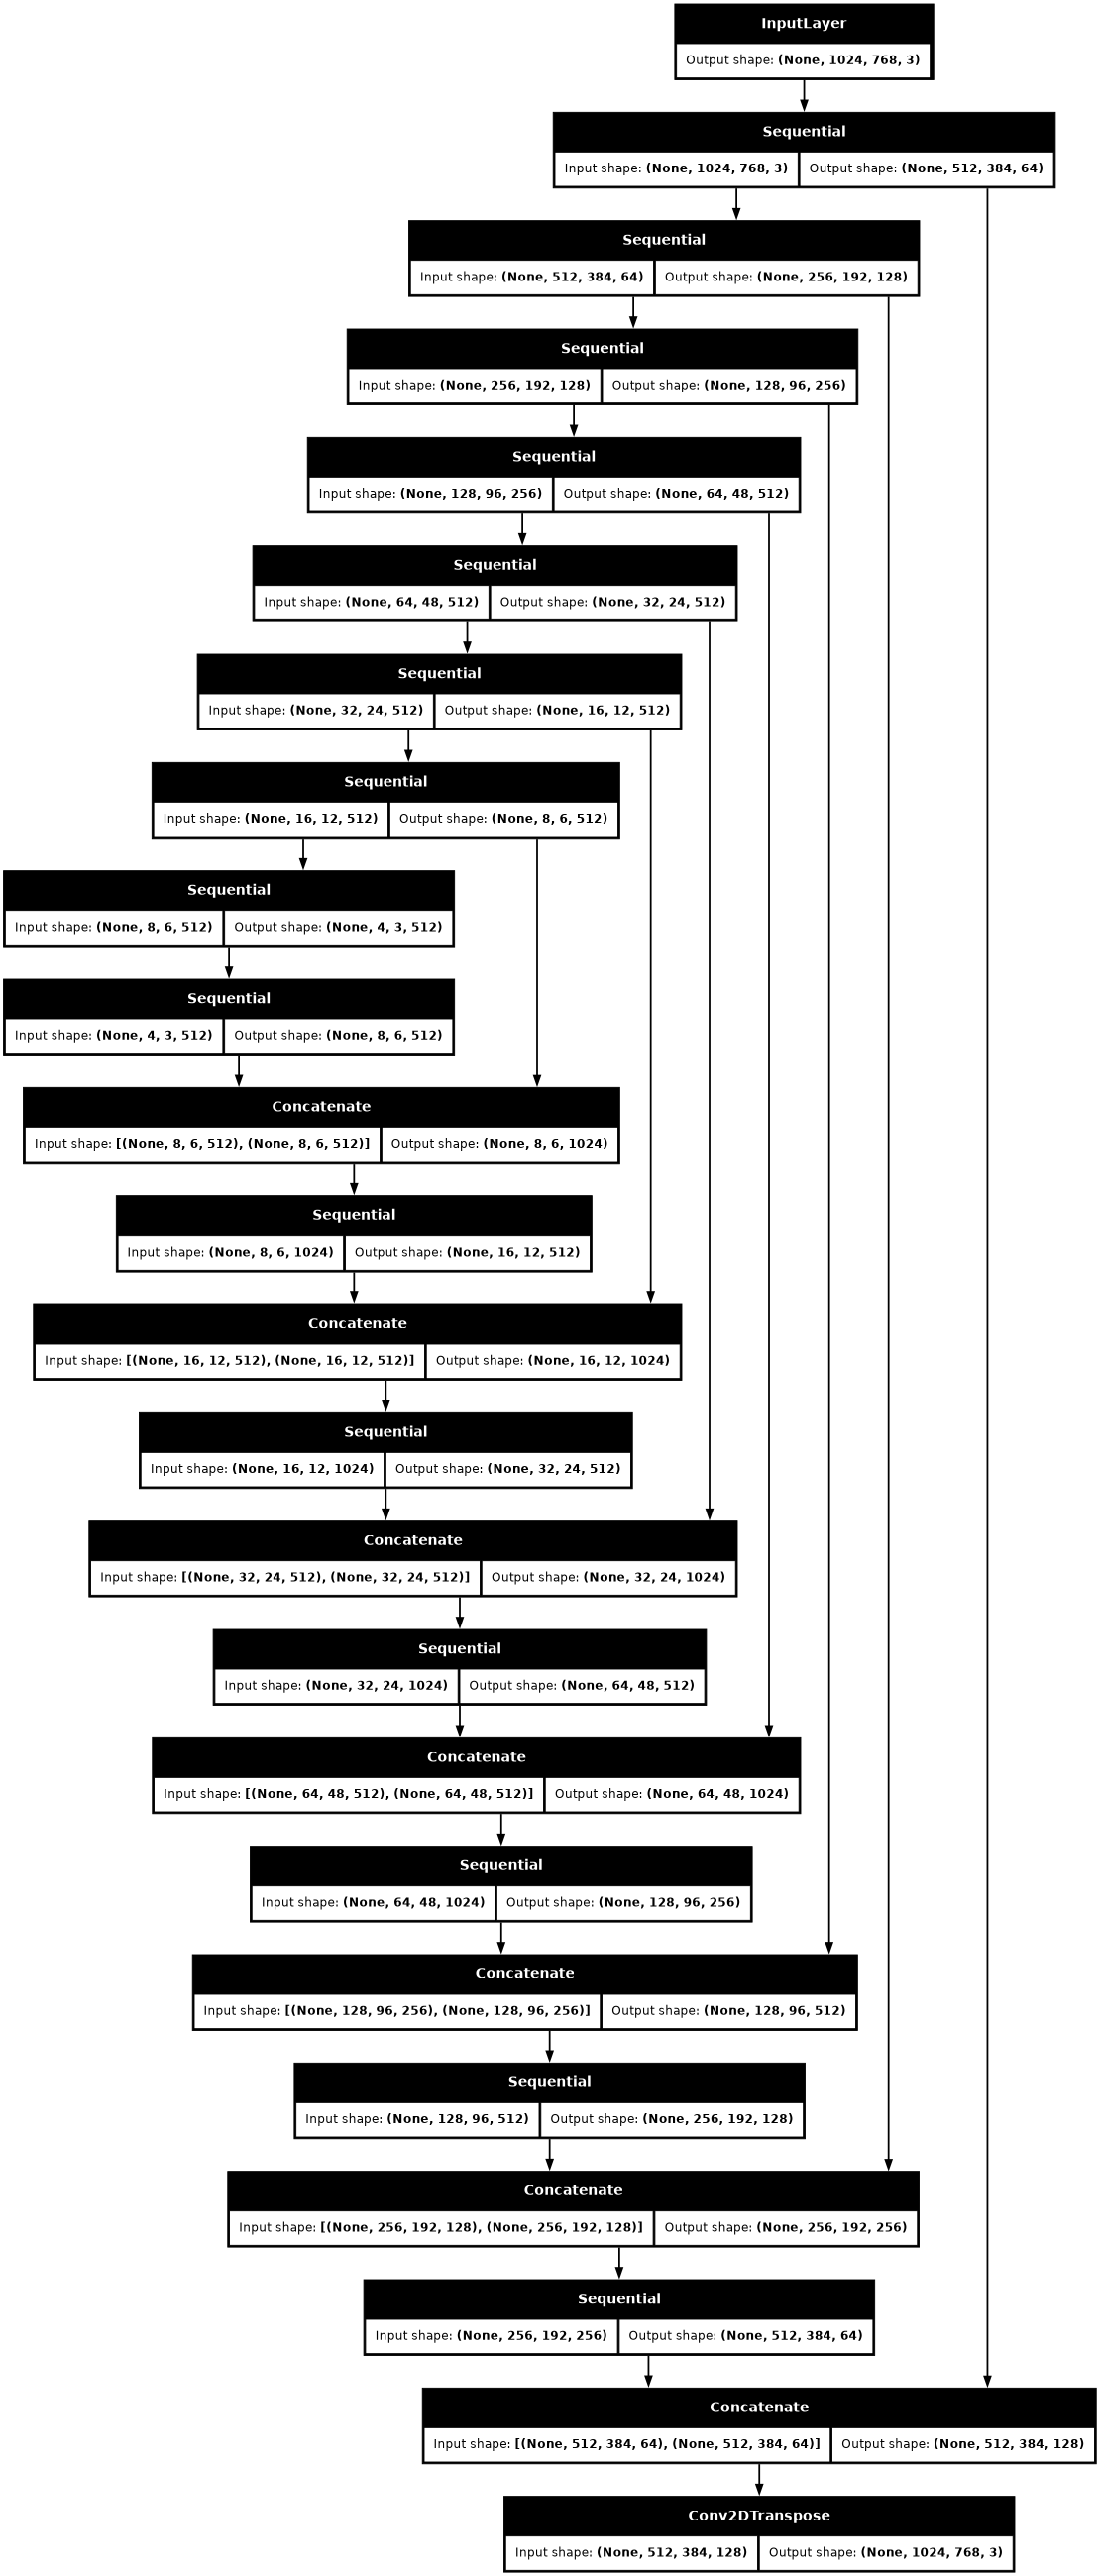

In [37]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)


In [40]:
#gen_output = generator(inp[tf.newaxis, ...], training=False)
#plt.imshow(gen_output[0, ...])


In [41]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss


In [42]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss


In [43]:

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


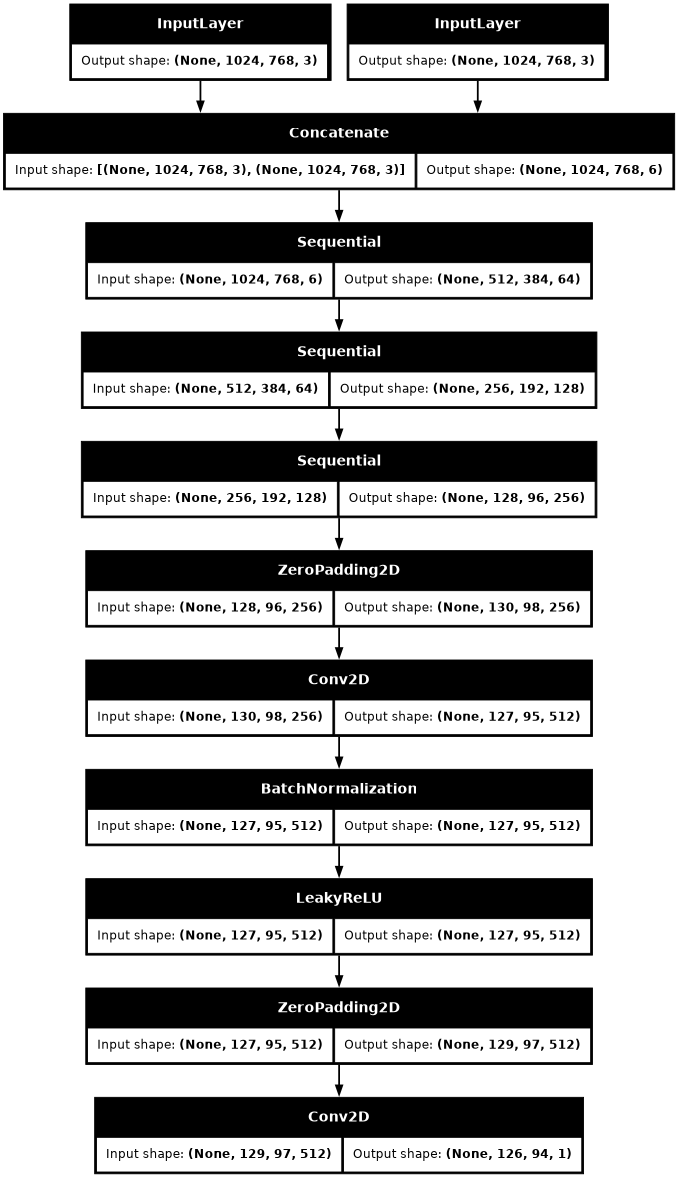

In [44]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)


In [26]:
#disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
#plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
#plt.colorbar()


In [45]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


In [46]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [47]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [48]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [49]:
def generate_images(model, test_input, tar):

    prediction = model(tf.expand_dims(test_input, 0), training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input, tar, prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


In [50]:
#for example_input, example_target in test_dataset.take(1):
#    generate_images(generator, example_input, example_target)


In [51]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [52]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image[0], training=True)

    disc_real_output = discriminator([input_image[0], target[0]], training=True)
    disc_generated_output = discriminator([input_image[0], gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [53]:
def fit(train_ds, test_ds, steps):
  inp_imgs = next(iter(test_ds.take(1)))
  example_input, example_target = inp_imgs[0], inp_imgs[1]
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)


In [56]:
#inp_imgs = next(iter(train_dataset.take(4)))
#example_input, example_target = inp_imgs[0], inp_imgs[1]
#generate_images(generator, example_input[0][0], example_target)

Time taken for 1000 steps: 473.86 sec



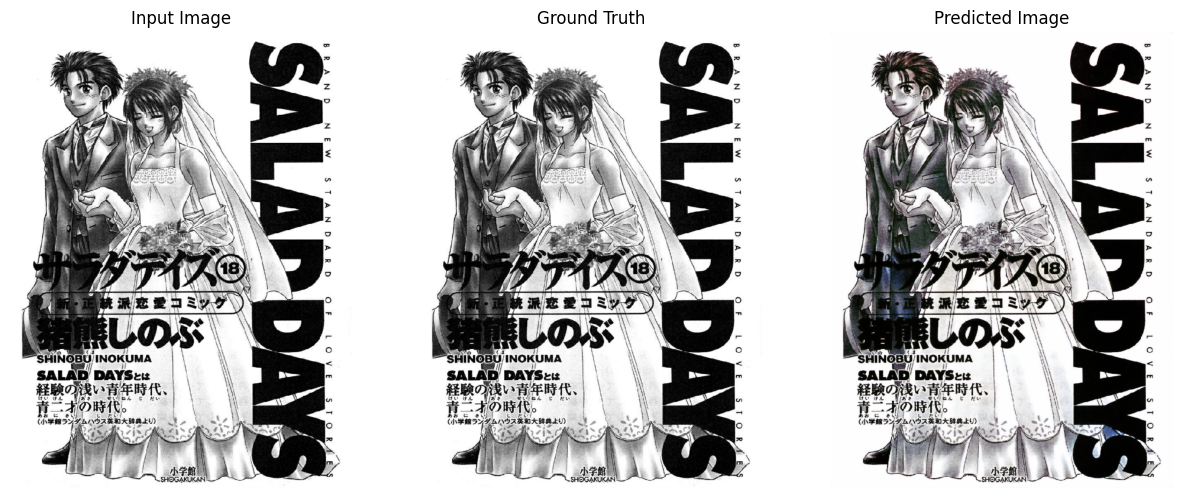

Step: 39k
....................................................................................................

In [57]:
fit(train_dataset, test_dataset, steps=40000)


In [58]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

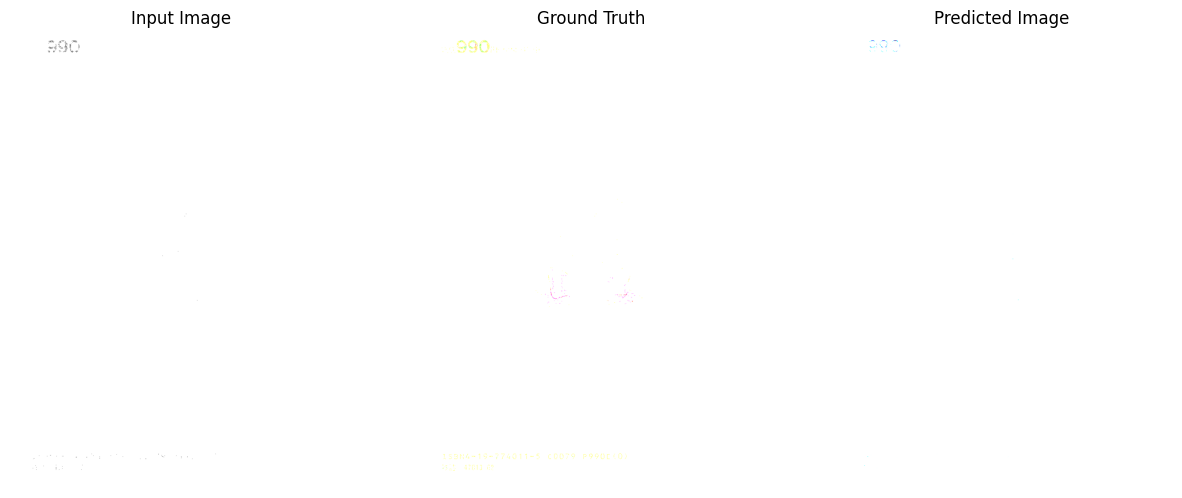

In [38]:
c,d = resize(a,b)
generate_images(generator,c,d )

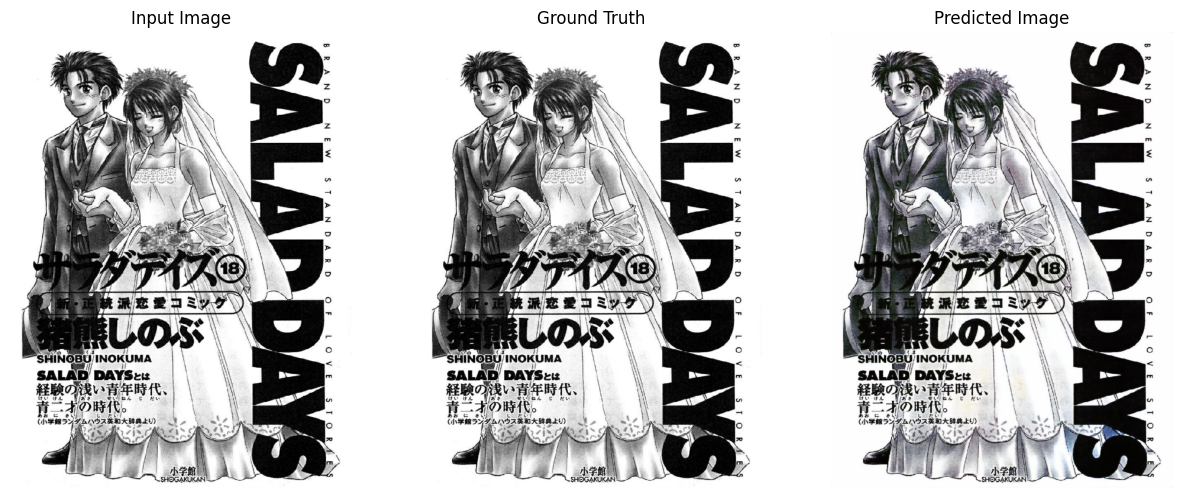

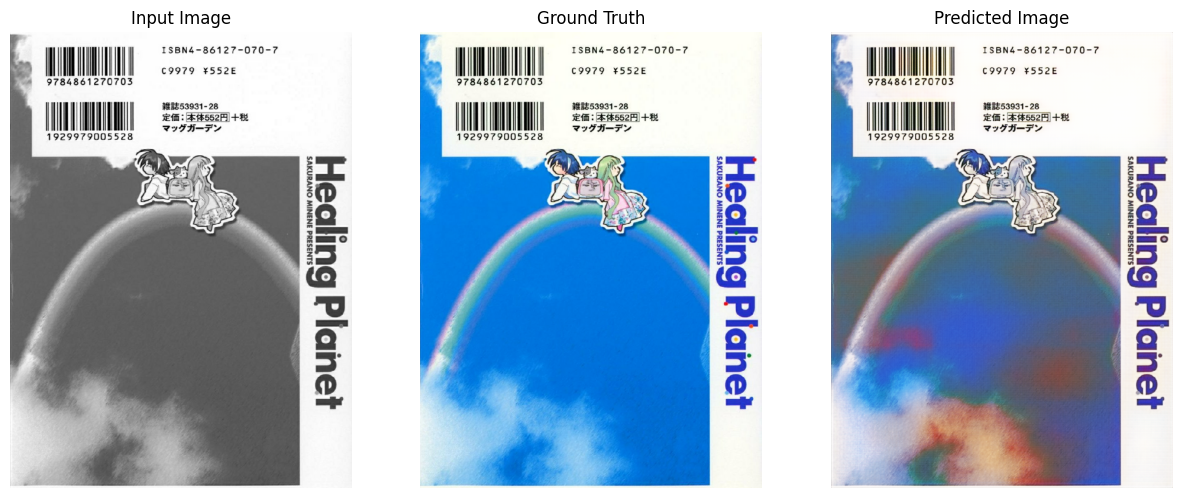

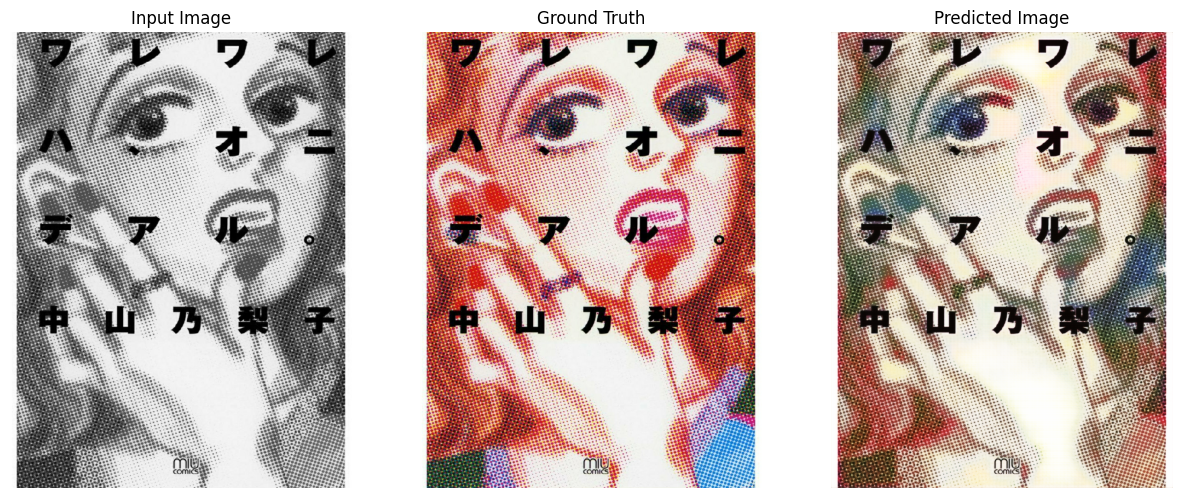

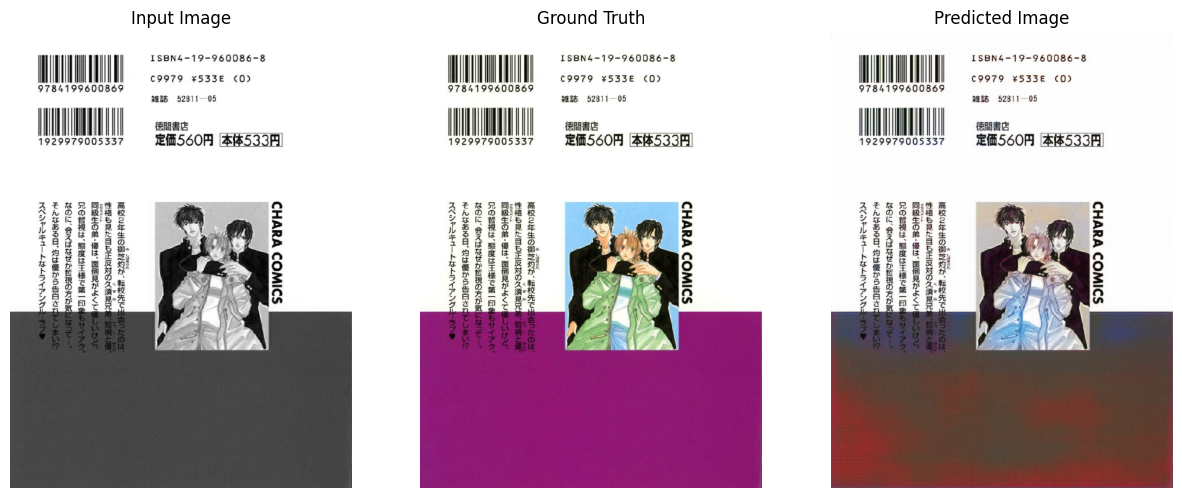

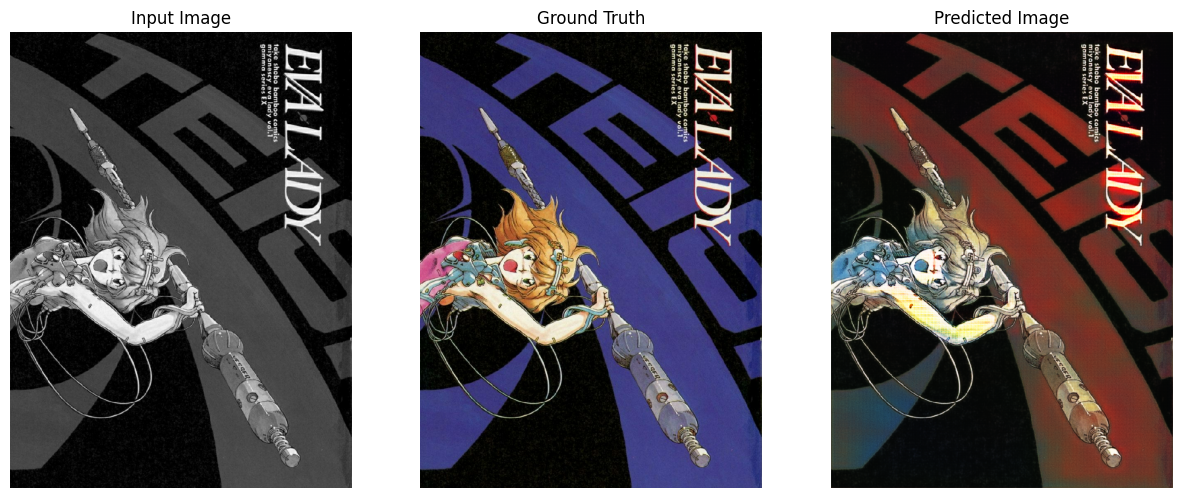

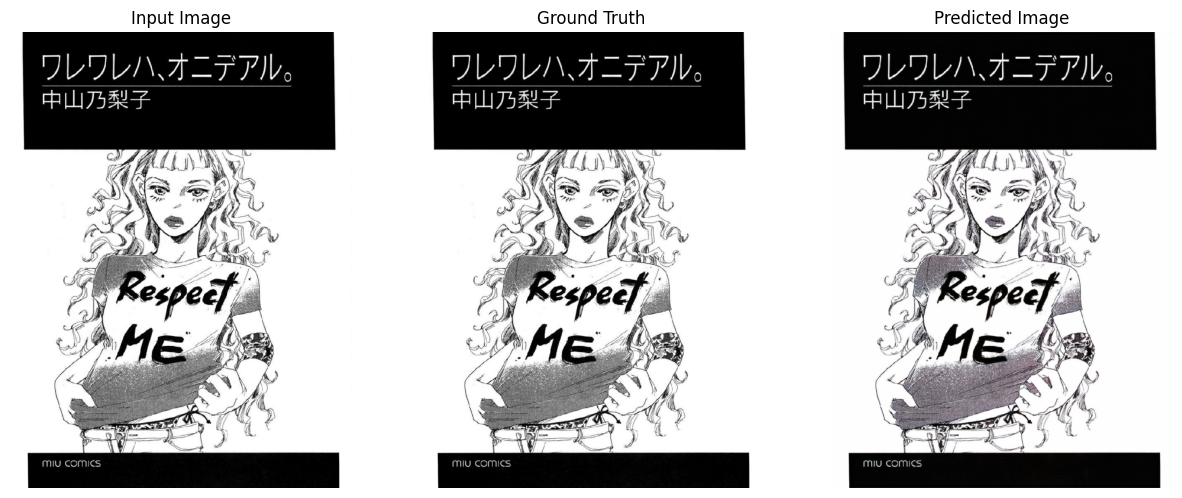

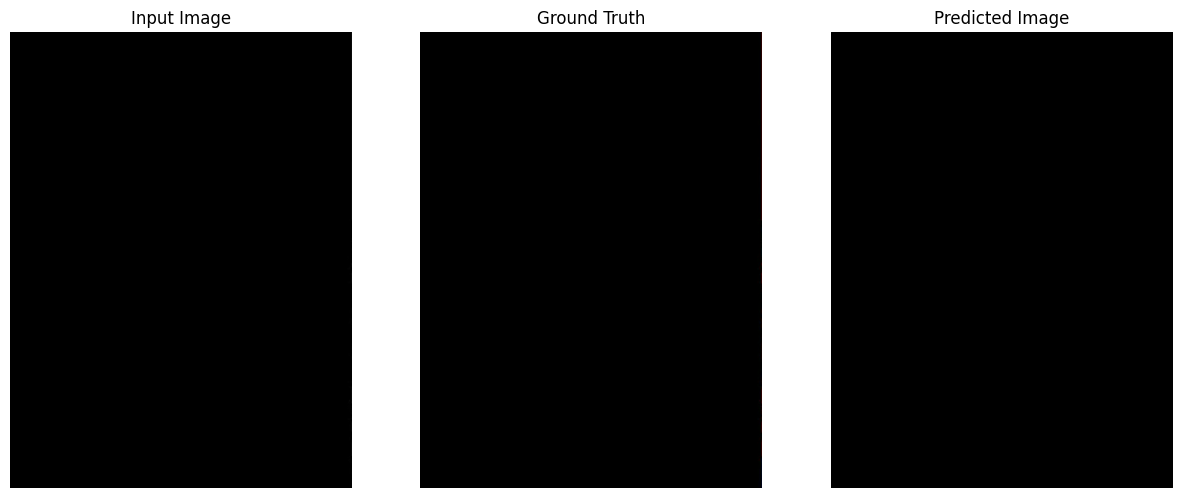

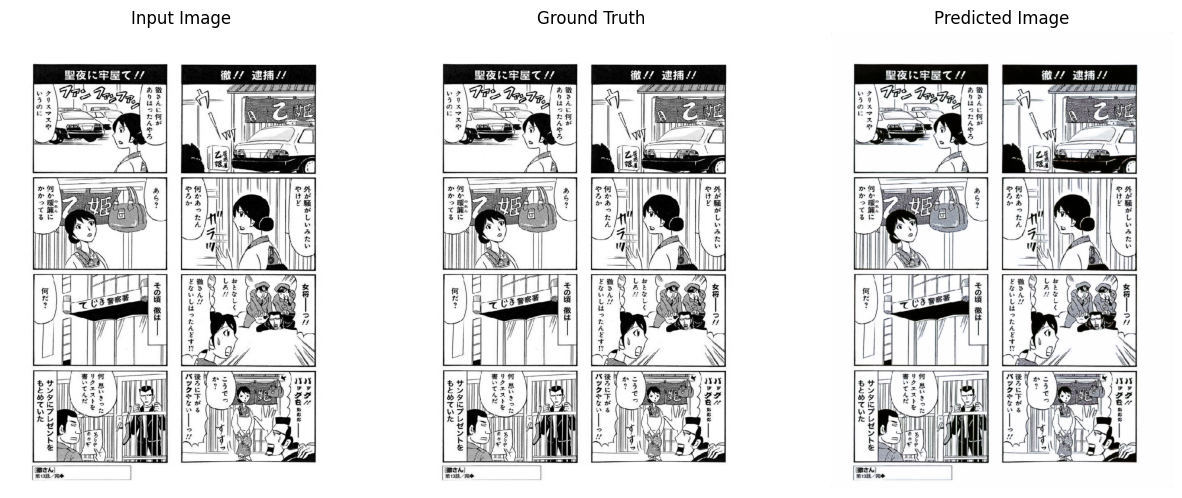

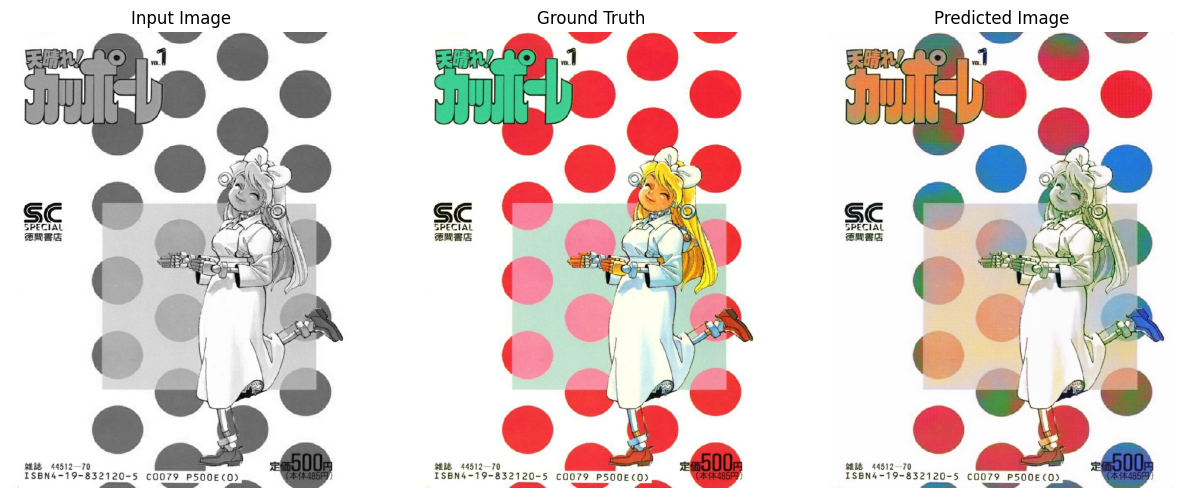

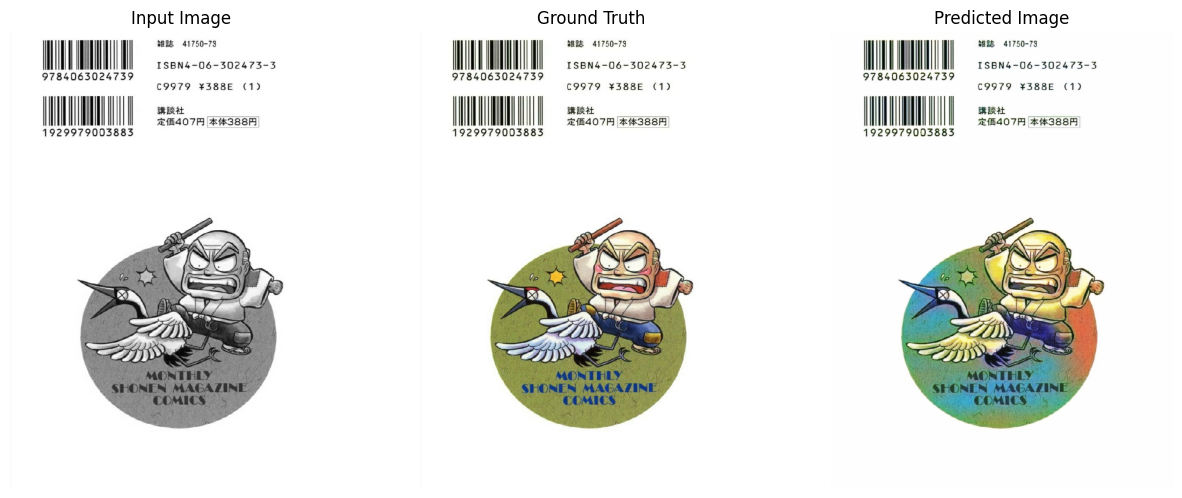

In [60]:
for inp, tar in test_dataset.take(10):
  generate_images(generator, inp, tar)


In [66]:
#!rm "/kaggle/working/Outputs.zip"

rm: cannot remove '/kaggle/working/Outputs.zip': No such file or directory


In [ ]:
import shutil
shutil.make_archive("working", 'zip', "/kaggle/working")

In [40]:
import glob
files = glob.glob("/kaggle/input/manga109-slice/*")
files

['/kaggle/input/manga109-slice/002.jpg',
 '/kaggle/input/manga109-slice/001.jpg',
 '/kaggle/input/manga109-slice/005.jpg',
 '/kaggle/input/manga109-slice/004.jpg',
 '/kaggle/input/manga109-slice/003.jpg',
 '/kaggle/input/manga109-slice/000.jpg']

In [47]:
target_real = ["/kaggle/input/cover-images-split/content/images_dataset/target137.jpg"]

In [26]:
#The featured training set consist of 436 images
BUFFER_SIZE = 436
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 1170 x 827 in size
IMG_WIDTH = 768#832#827
IMG_HEIGHT = 1024#1184#1170